<a id='top'></a>
# Plate boundary lengths through time


** Table of Contents: **
* <a href='#Part 1'> Get length of plate boundaries </a>
    * <a href='#Loop'> Functions </a>
    * <a href='#Execution'> Execution </a>
    * <a href='#Map'> Plotted on a map </a> and <a href='#map gif'> shown as a gif </a>
    * <a href='#xy graph'> Plotted as an xy graph </a>

------

<a href='#top'>Back to top</a> | <a href='#Loop'> Skip to loop</a> | <a href='#Execution'>Skip to execution</a> | <a href='#Map'>Skip to map</a> | <a href='#map gif'>Skip to gif</a> | <a href='#xy graph'>Skip to xy graph</a>


<a id='Part 1'></a> 
## Part 1: Get length of plate boundaries from AREPS model.

This part of the notebook gets the length of plate boundaries through time using pygplates.

This requires the rotation file and topologies. Mid ocean ridge segments are split into 'transform' and 'ridge' segments, based on the angle difference in the stage pole(?) for each feature. Currently the angle is (user-set to) 70°.


This part of the workflow uses a modified version (by me) of Müller et al. (2016; AREPS). Modifications are to the gpml type for some plate boundaries.

---

Import dependencies

In [2]:
import pygplates
print "imported pygplates"
import numpy as np
print "imported numpy"
import matplotlib.pyplot as plt
print "imported pyplot"
%matplotlib inline
import pandas as pd
import os
from IPython.display import Image
# from mpl_toolkits.basemap import Basemap
# from matplotlib.patches import Polygon
# import matplotlib.lines as mlines

imported pygplates
imported numpy
imported pyplot


Define GPlates files and read in using pygplates. Using files from Müller et al. (2016), from the svn.
Also import coastlines, for plotting later on.

In [3]:
# datadir = '/Users/nickywright/Documents/Data/svn/Muller++_2015_AREPS/'
#datadir = '/Volumes/nmw/Documents/Data/svn/Muller++_2015_AREPS/'

#Using rotation and plate boundaries of Mathews 2016

rotfile_List = 'Global_EB_250-0Ma_GK07_Matthews++.rot'
#Change plate boundary file by removing NW, personal of Nicky Wright, and remove datadir
GPML_List = ['TopologyBuildingBlocks_Matthews++.gpml',\
             'Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz']

# GPML_List = [datadir + 'Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml',\
#              datadir + 'Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml']

coastlines_file = 'Coastlines_low_res_Matthews++.gpml'
print "imported Rotation file, plate boundaries and topologies"

imported Rotation file, plate boundaries and topologies


---
<a href='#top'>Back to top</a> | <a href='#Part 1'> Back to Part 1</a> | <a href='#Execution'>Skip to execution</a> | <a href='#Map'>Skip to map</a> | <a href='#map gif'>Skip to gif</a> | <a href='#xy graph'>Skip to xy graph</a>

<a id='Loop'></a>

### Use loop to search through plate boundary types and write to a new file

The first function ("plateboundarytype_outpandas") is a loop to write out the plate boundary types from the topology file, between user-defined min and max times. It then writes all the output to a \*.h5 or \*.csv file, which can then be interrogated with pandas.
It writes out **each segment** of the plate boundary.

The second function ("plate_boundary_plotting_prep_loop") filters the output from "plateboundarytype_pandas" into plottable files. It also separates transform and ridges from the gpml:MidOceanRidges, based on a user-specified deviation angle (recommended is 70°).

In [4]:
def plateboundarytype_outpandas(rotfile_List, topology_features, min_time,\
                                max_time, time_step, outfilename):
    """ This is a function to interrogate plate boundary types through time. It takes
    the rotation model and topological features, and outputs information about *each
    segment* of plate boundaries. Information includes gpml type (e.g. MidOceanRidges,
    SubductionZone, etc), plate IDs, length of each segment (km), and deviation angle
    (°) between the transform and mid ocean ridge segments (useful for splitting
    transforms vs. ridges in a gpml:MidOceanRidge type).

    Required:
    - rotation file
    - topology files
    - miniumum time (lower number)
    - maximum time (higher number)
    - time step
    - name of output file
    """ 
    
    # -------------------------------------------------------------
    # --- Set up things
    # Set up time array
    times = np.arange(min_time,max_time + 1,time_step)
    
    # value to split ridges vs. transforms.
    isochron_segment_deviation_in_radians = np.radians(70)
    
    # Read in rotation and topology files with pygplates
    rotation_model = pygplates.RotationModel(rotfile_List)
    topology_features = pygplates.FeatureCollection()
    for file in GPML_List:
        topology_feature = pygplates.FeatureCollection(file)
        topology_features.add(topology_feature)
    
    # create empty file to add all values to
    segment_list = []
    
    # -------------------------------------------------------------
    # Begin loop
    for time in times: 
        
        point_plot_X = []            # empty coordinate arrays
        point_plot_Y = []            # empty coordinate arrays

        wrapper = pygplates.DateLineWrapper()            # create a dateline wrapper object
        
        # Resolve our topological plate polygons (and deforming networks) to the current 'time'.
        # We generate both the resolved topology boundaries and the boundary sections between them.
        resolved_topologies = []
        shared_boundary_sections = []
        pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, \
                                     time, shared_boundary_sections)

        # -------------------------------------------------------------
        # Iterate over the shared boundary sections.
        for shared_boundary_section in shared_boundary_sections:
           
            # -------------------------------------------------------------
            # The shared sub-segments contribute either to the ridges or to the subduction zones.
            # create a case for the MORs
            if shared_boundary_section.get_feature().get_feature_type() == \
            pygplates.FeatureType.create_gpml('MidOceanRidge'):

                # Ignore zero length segments - they don't have a direction.
                for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():

                    # ADD SOME CODE HERE TO SEPARATE INTO RIDGE AND TRENCH
                    left_plate_id = shared_sub_segment.get_feature().get_left_plate()
                    right_plate_id = shared_sub_segment.get_feature().get_right_plate()
                    stage_rotation = rotation_model.get_rotation(time +1 , left_plate_id, \
                                                                 time, right_plate_id, 0)
                    finite_rotation = rotation_model.get_rotation(time, right_plate_id, 0, 0)
                    stage_pole, stage_angle_radians = stage_rotation.get_euler_pole_and_angle()
                    stage_pole_recon = finite_rotation * stage_pole

                    for segment in shared_sub_segment.get_geometry().get_segments():
                        split_geometry = wrapper.wrap(pygplates.PolylineOnSphere((segment.get_start_point(),
                                                                                 segment.get_end_point())),0.1)
                        if segment.is_zero_length():    # check to see if segment is zero length
                            continue

                        # Get the point in the middle of the segment and its tangential direction.
                        segment_midpoint = segment.get_arc_point(0.5)
                        segment_direction_at_midpoint = segment.get_arc_direction(0.5)
                                            
                        # Get the direction from the segment midpoint to the stage pole.
                        # This is the tangential direction at the start of an arc from the segment
                        # midpoint to the stage pole (the zero parameter indicates the arc start
                        # point which is the segment midpoint).
                        segment_to_stage_pole_direction = pygplates.GreatCircleArc(
                                segment_midpoint, stage_pole_recon).get_arc_direction(0)

                        # The angle that the segment deviates from the stage pole direction.
                        deviation_of_segment_direction_from_stage_pole = \
                        pygplates.Vector3D.angle_between(segment_direction_at_midpoint,\
                                                         segment_to_stage_pole_direction)

                        # Change the angle to be between 0 and 90
                        deviation_of_segment_direction_from_stage_pole_mod = \
                        90-np.abs(90-np.remainder(np.degrees(deviation_of_segment_direction_from_stage_pole),\
                                                  180))
                        # make file for plotting on a map
                        for geometry in split_geometry:
                            point_X = []
                            point_Y = []
                            for point in geometry.get_points():
                                point_X.append(point.get_longitude()),point_Y.append(point.get_latitude())
                        # append to map plot file
                        point_plot_X.append(point_X)
                        point_plot_Y.append(point_Y)
                        
                        segment_list.append((segment.get_start_point().to_lat_lon()[0],\
                                             segment.get_start_point().to_lat_lon()[1],\
                                             segment.get_end_point().to_lat_lon()[0],\
                                             segment.get_end_point().to_lat_lon()[1],\
                                             segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms,\
                                             deviation_of_segment_direction_from_stage_pole,\
                                             deviation_of_segment_direction_from_stage_pole_mod,\
                                             stage_angle_radians,\
                                             str(shared_boundary_section.get_feature().get_feature_type()),\
                                             str(shared_boundary_section.get_feature().get_left_plate()),\
                                             str(shared_boundary_section.get_feature().get_right_plate()),\
                                             str(shared_boundary_section.get_feature().get_reconstruction_plate_id()),\
                                             str(shared_boundary_section.get_feature().get_name()),\
                                             str(shared_boundary_section.get_feature().get_valid_time()),\
                                             time))                   
  
            # -------------------------------------------------------------
            # If the topology section does not fall into the MOR category, put it here
            else:
                for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():

                    # get the stage pole for each segment
                    left_plate_id = shared_sub_segment.get_feature().get_left_plate()
                    right_plate_id = shared_sub_segment.get_feature().get_right_plate()
                    stage_rotation = rotation_model.get_rotation(time + 1, left_plate_id, \
                                                                 time, right_plate_id, 0)
                    finite_rotation = rotation_model.get_rotation(time, right_plate_id, 0, 0)
                    stage_pole, stage_angle_radians = stage_rotation.get_euler_pole_and_angle()
                    stage_pole_recon = finite_rotation * stage_pole

                    for segment in shared_sub_segment.get_geometry().get_segments():
                        split_geometry = wrapper.wrap(pygplates.PolylineOnSphere((segment.get_start_point(),
                                                                                 segment.get_end_point())),0.1)
                        if segment.is_zero_length():    # check to see if segment is zero length
                            continue

                        # Get the point in the middle of the segment and its tangential direction.
                        segment_midpoint = segment.get_arc_point(0.5)
                        segment_direction_at_midpoint = segment.get_arc_direction(0.5)

                        # Get the direction from the segment midpoint to the stage pole.
                        # This is the tangential direction at the start of an arc from the segment
                        # midpoint to the stage pole (the zero parameter indicates the arc start
                        # point which is the segment midpoint).
                        segment_to_stage_pole_direction = pygplates.GreatCircleArc(
                                segment_midpoint, stage_pole_recon).get_arc_direction(0)

                        # The angle that the segment deviates from the stage pole direction.
                        deviation_of_segment_direction_from_stage_pole = pygplates.Vector3D.angle_between(
                                segment_direction_at_midpoint, segment_to_stage_pole_direction)

                        # Change the angle to be between 0 and 90
                        deviation_of_segment_direction_from_stage_pole_mod = \
                        90-np.abs(90-np.remainder(np.degrees(deviation_of_segment_direction_from_stage_pole),180))
   
                        # make file for plotting on a map
                        for geometry in split_geometry:
                            point_X = []
                            point_Y = []
                            for point in geometry.get_points():
                                point_X.append(point.get_longitude()),point_Y.append(point.get_latitude())
                        # append to map plot file
                        point_plot_X.append(point_X)
                        point_plot_Y.append(point_Y)
                        
                        segment_list.append((segment.get_start_point().to_lat_lon()[0],\
                                             segment.get_start_point().to_lat_lon()[1],\
                                             segment.get_end_point().to_lat_lon()[0],\
                                             segment.get_end_point().to_lat_lon()[1],\
                                             segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms,\
                                             deviation_of_segment_direction_from_stage_pole,\
                                             deviation_of_segment_direction_from_stage_pole_mod,\
                                             stage_angle_radians,\
                                             str(shared_boundary_section.get_feature().get_feature_type()),\
                                             str(shared_boundary_section.get_feature().get_left_plate()),\
                                             str(shared_boundary_section.get_feature().get_right_plate()),\
                                             str(shared_boundary_section.get_feature().get_reconstruction_plate_id()),\
                                             str(shared_boundary_section.get_feature().get_name()),\
                                             str(shared_boundary_section.get_feature().get_valid_time()),\
                                             time))          
        
   
        # -------------------------------------------------------------
    DataFrameTemplate = ('StartPointLat', 'StartPointLon','EndPointLat','EndPointLon',
                         'Length_km','Deviation', 'Deviation_mod_deg',
                         'StagePole_rad', 'FeatureType','LeftPlate', 'RightPlate',\
                         'PlateID', 'Name', 'Valid_time', 'Time_Ma')
    # Save to an hdf5 file
    df = pd.DataFrame(segment_list, columns=DataFrameTemplate)
    df.to_hdf(outfilename + '.h5', 'Statistics_table') 


# define function to plot 
def plate_boundary_plotting_prep_loop(infile, outfiledir, min_time, max_time, time_step, deviationangle):
    file = infile

    df = pd.read_hdf(file,'Statistics_table')
    
    # Set up time array
    times = np.arange(min_time,max_time + 1,time_step)
    
#     deviation_angle = np.radians(deviationangle)  # do not do this in radians!!
    deviation_angle = deviationangle
    # Begin loop
    for time in times: 
        # get ridges out
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:MidOceanRidge') \
            & (df['Deviation_mod_deg'] <= deviation_angle)]
        # write out file using pandas. Begin column names with number, so they end up in this order
        # by default, pandas organises things in alphabetical order.
        # --- ridges
        outfile_ridges = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile_ridges.to_csv(str(outfiledir) + '/ridges_%sMa.csv' % time, header=True, \
                              cols=False, sep=',', index=False, float_format='%0.2f')
        
        # ---- transforms from MORs
        subset_transformsfromMORs = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:MidOceanRidge') \
            & (df['Deviation_mod_deg'] > deviation_angle)]
        outfile_transforms_from_MORs = pd.DataFrame({'01_Start_Lat': list(subset_transformsfromMORs.StartPointLat),
                           '02_Start_Lon': list(subset_transformsfromMORs.StartPointLon),
                           '03_End_Lat': list(subset_transformsfromMORs.EndPointLat),
                           '04_End_Lon': list(subset_transformsfromMORs.EndPointLon),
                           '05_FeatureType': list(subset_transformsfromMORs.FeatureType),
                           '06_Name': list(subset_transformsfromMORs.Name),
                           '07_PlateID': list(subset_transformsfromMORs.PlateID),
                           '08_RightPlateID': list(subset_transformsfromMORs.RightPlate),
                           '09_LeftPlateID': list(subset_transformsfromMORs.LeftPlate),
                           '10_StagePole': list(subset_transformsfromMORs.StagePole_rad),
                           '11_Deviation': list(subset_transformsfromMORs.Deviation),
                           '12_Deviation_mod': list(subset_transformsfromMORs.Deviation_mod_deg)})
        outfile_transforms_from_MORs.to_csv(str(outfiledir) + '/transform_%sMa.csv' % time, header=True, \
                                            cols=False, sep=',', index=False, float_format='%0.2f') 
        # ---- Subduction zones
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:SubductionZone')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv(str(outfiledir) + '/subzone_%sMa.csv' % time, header=True, cols=False, \
                       sep=',', index=False, float_format='%0.2f') 

        # get inferred paleo boundaries out
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:InferredPaleoBoundary')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv( str(outfiledir) + '/inferredpb_%sMa.csv' % time, header=True, cols=False, \
                       sep=',', index=False, float_format='%0.2f') 
        
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:Transform')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv(str(outfiledir) + '/transform_gpml_%sMa.csv' % time, header=True, cols=False,\
                       sep=',', index=False, float_format='%0.2f') 
        
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:Fault')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv(str(outfiledir) + '/fault_%sMa.csv' % time, header=True, cols=False, sep=',', \
                       index=False, float_format='%0.2f') 
        
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:UnclassifiedFeature')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv(str(outfiledir) + '/unclassified_%sMa.csv' % time, header=True, cols=False, \
                       sep=',', index=False, float_format='%0.2f') 
        
        
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:OrogenicBelt')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv(str(outfiledir) + '/orogenicbelt_%sMa.csv' % time, header=True, cols=False, \
                       sep=',', index=False, float_format='%0.2f') 
        
        
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:ContinentalRift')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv(str(outfiledir) + '/continentalrift_%sMa.csv' % time, header=True, cols=False, \
                       sep=',', index=False, float_format='%0.2f') 
        
        
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:FractureZone')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv(str(outfiledir) + '/fracturezone_%sMa.csv' % time, header=True, cols=False, \
                       sep=',', index=False, float_format='%0.2f') 
        
        
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:TerraneBoundary')]
        outfile = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile.to_csv(str(outfiledir) + '/terraneboundary_%sMa.csv' % time, header=True, cols=False,\
                       sep=',', index=False, float_format='%0.2f') 

        # --- back arc ridges
        subset = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:TectonicSection') \
                    & (df['Deviation_mod_deg'] <= deviation_angle)]
        outfile_ridges = pd.DataFrame({'01_Start_Lat': list(subset.StartPointLat),
                           '02_Start_Lon': list(subset.StartPointLon),
                           '03_End_Lat': list(subset.EndPointLat),
                           '04_End_Lon': list(subset.EndPointLon),
                           '05_FeatureType': list(subset.FeatureType),
                           '06_Name': list(subset.Name),
                           '07_PlateID': list(subset.PlateID),
                           '08_RightPlateID': list(subset.RightPlate),
                           '09_LeftPlateID': list(subset.LeftPlate),
                           '10_StagePole': list(subset.StagePole_rad),
                           '11_Deviation': list(subset.Deviation),
                           '12_Deviation_mod': list(subset.Deviation_mod_deg)})
        outfile_ridges.to_csv(str(outfiledir) + '/activebackarc_ridge_%sMa.csv' % time, header=True, \
                              cols=False, sep=',', index=False, float_format='%0.2f')
        
        # ---- transforms from MORs
        subset_transformsfromMORs = df[ (df['Time_Ma'] == time) & (df['FeatureType']=='gpml:TectonicSection') \
            & (df['Deviation_mod_deg'] > deviation_angle)]
        outfile_transforms_from_MORs = pd.DataFrame({'01_Start_Lat': list(subset_transformsfromMORs.StartPointLat),
                           '02_Start_Lon': list(subset_transformsfromMORs.StartPointLon),
                           '03_End_Lat': list(subset_transformsfromMORs.EndPointLat),
                           '04_End_Lon': list(subset_transformsfromMORs.EndPointLon),
                           '05_FeatureType': list(subset_transformsfromMORs.FeatureType),
                           '06_Name': list(subset_transformsfromMORs.Name),
                           '07_PlateID': list(subset_transformsfromMORs.PlateID),
                           '08_RightPlateID': list(subset_transformsfromMORs.RightPlate),
                           '09_LeftPlateID': list(subset_transformsfromMORs.LeftPlate),
                           '10_StagePole': list(subset_transformsfromMORs.StagePole_rad),
                           '11_Deviation': list(subset_transformsfromMORs.Deviation),
                           '12_Deviation_mod': list(subset_transformsfromMORs.Deviation_mod_deg)})
        outfile_transforms_from_MORs.to_csv(str(outfiledir) + '/activebackarc_transform_%sMa.csv' % time, header=True, \
                                            cols=False, sep=',', index=False, float_format='%0.2f') 


Create a loop to create reconstructed coastline files. This is purely for plotting with GMT later on.

In [4]:
def coastline_export_loop(rotfile_List, coastlines_file, outfiledir, min_time, max_time, time_step):
    times = np.arange(min_time,max_time + 1,time_step)
    for time in times: 
        rotation_model = pygplates.RotationModel(rotfile_List)
        pygplates.reconstruct(coastlines_file, rotation_model, str(outfiledir) + '/coastlines_%sMa.xy' % time, time, 1)

---
<a href='#top'>Back to top</a> | <a href='#Part 1'> Back to Part 1</a> | <a href='#Loop'>Back to loop</a> | <a href='#Map'>Skip to map</a> | <a href='#map gif'>Skip to gif</a> | <a href='#xy graph'>Skip to xy graph</a>
<a id='Execution'></a> 
### Run loop and get an output file

Here we run functions created above. We need to specify a min and max time, and a time interval.
We will then split the files into feature and age files (this creates ALOT of temp files).

In [5]:
min_time = 0
max_time = 200
time_step = 1

filename='PlateBoundaryTypes_14March17'

# get plate boundary types
plateboundarytype_outpandas(rotfile_List, GPML_List, min_time, max_time, time_step, filename)

folder="tmp"
os.system('mkdir tmp')
deviationangle = 70

plate_boundary_plotting_prep_loop(str(filename) + '.h5', folder , min_time, max_time, time_step, deviationangle)

Use pygplates to get coastlines out, for plotting purposes.

In [ ]:
coastline_export_loop(rotfile_List, coastlines_file, folder, min_time, max_time, time_step)

---
<a href='#top'>Back to top</a> | <a href='#Part 1'> Back to Part 1</a> | <a href='#Loop'> Back to loop</a> | <a href='#Execution'>Back to execution</a> | <a href='#map gif'>Skip to gif</a> | <a href='#xy graph'>Skip to xy graph</a>

<a id='Map'></a> 
### Plot on a map

Reformat the files and plot with GMT.
Matplotlib's Basemap has an issue when plotting these points (maybe a dateline issue?).

In [ ]:
%%bash 

gmt gmtset FONT_ANNOT_PRIMARY 8p,Helvetica,black FONT_LABEL 10p,Helvetica,black

# variables
age=0
maxage=200
folder=tmp

cpt=aaa.cpt
gmt makecpt -T0/90/2 -Cjet > $cpt

# loop to reformat files
while (( $age <= $maxage ))
    do
    for i in transform ridges subzone continentalrift fault fracturezone inferredpb orogenicbelt terraneboundary transform_gpml unclassified activebackarc_ridge activebackarc_transform
        do
        file=$folder/${i}_${age}Ma.csv
        # ---- get this file into the correct format. first get the start and end points into a new file - order as lon, lat
        awk 'BEGIN {FS = ","}; {print $2, $1, $12}' $file > startpoint.tmp
        awk 'BEGIN {FS = ","}; {print $4, $3, $12}' $file > endpoint.tmp
        # add a blank space between every line
        awk '{ if ((NR % 1) == 0) printf("\n"); print; }' startpoint.tmp > startpoint2.tmp
        awk '{ if ((NR % 1) == 0) printf("\n"); print; }' endpoint.tmp > endpoint2.tmp
        # get rid of a row from the startpoint file, so the files are offset a little
        awk '{if (NR != 1) print $0}' startpoint2.tmp > startpoint3.tmp
        # combine the two files together
        paste startpoint3.tmp endpoint2.tmp | column -t -s" " > aaa.tmp
        # format file to only have 1 space between values - needed for python script
        awk '{ if (NR > 2) printf("%0.2f %0.2f %0.2f\n", $1, $2, $3)}' aaa.tmp > bbb.tmp
        # add character to say end of segment
        awk '1;!(NR%2){print ">";}' bbb.tmp  > ccc.tmp
        # add header line
        awk 'BEGIN{print ">"}1' ccc.tmp > plot_${i}.tmp
        done
# --- plot with GMT
region=d
projection=W
width=18
psfile=$folder/plateboundaries_${age}.ps
width_scale=`echo "scale=2; $width - 1" | bc `
width_scale_x=`echo "scale=2; $width/2" | bc `

# -- colours
ridge_col=red
transform_col=blue
subductionzone_col=forestgreen
transform_gpml_col=lightblue
terraneboundary_col=pink
orogenicbelt_col=orange
inferredpb_col=brown
fracturezone_col=blue4
fault_col=purple
continentalrift_col=salmon
unclassified_col=grey
activebackarc_ridge_col=black
activebackarc_transform_col=magenta

gmt psbasemap -J${projection}${width} -R${region} -Ba0:: -Xc -Y19 -K -P > $psfile
gmt psxy $folder/coastlines_${age}Ma.xy -R -J -Glightgrey -K -O >> $psfile
# colour by type
gmt psxy -J -R plot_ridges.tmp -W1,$ridge_col -K -O >> $psfile
gmt psxy -J -R plot_transform.tmp -W1,$transform_col -K -O >> $psfile
gmt psxy -J -R plot_subzone.tmp -W1,$subductionzone_col -K -O >> $psfile
gmt psxy -J -R plot_transform_gpml.tmp -W1,$transform_gpml_col -K -O >> $psfile
gmt psxy -J -R plot_terraneboundary.tmp -W1,$terraneboundary_col -K -O >> $psfile
gmt psxy -J -R plot_orogenicbelt.tmp -W1,$orogenicbelt_col -K -O >> $psfile
gmt psxy -J -R plot_inferredpb.tmp -W1,$inferredpb_col -K -O >> $psfile
gmt psxy -J -R plot_fracturezone.tmp -W1,$fracturezone_col -K -O >> $psfile
gmt psxy -J -R plot_fault.tmp -W1,$fault_col -K -O >> $psfile
gmt psxy -J -R plot_continentalrift.tmp -W1,$continentalrift_col -K -O >> $psfile
gmt psxy -J -R plot_unclassified.tmp -W1,$unclassified_col -K -O >> $psfile
gmt psxy -J -R plot_activebackarc_ridge.tmp -W2,$activebackarc_ridge_col -K -O >> $psfile
gmt psxy -J -R plot_activebackarc_transform.tmp -W2,$activebackarc_transform_col -K -O >> $psfile

gmt psbasemap -J -R -Ba30 -K -O >> $psfile

echo "0 80 $age Ma" | gmt pstext -R -J -F+a0+f15p,Helvetica-Bold,black+jLM -K -O -Dj-8.5/0 -N >> $psfile

gmt pslegend -J -R -Dx0/0.5/10.5/1.9/LT -F+pthin+gwhite -O -K <<end >> $psfile
N 3
S 0.25 - 0.35 $ridge_col          1,$ridge_col                  0.6 Ridges
S 0.25 - 0.35 $transform_col      1,$transform_col              0.6 Transforms
S 0.25 - 0.35 $transform_gpml_col 1,$transform_gpml_col         0.6 Transforms (gpml)
S 0.25 - 0.35 $fracturezone_col   1,$fracturezone_col           0.6 Fracture zone
S 0.25 - 0.35 $subductionzone_col 1,$subductionzone_col         0.6 Subduction zones
S 0.25 - 0.35 $terraneboundary_col 1,$terraneboundary_col       0.6 Terrane boundary
S 0.25 - 0.35 $orogenicbelt_col   1,$orogenicbelt_col           0.6 Orogenic belt
S 0.25 - 0.35 $inferredpb_col     1,$inferredpb_col             0.6 Inferred paleoboundary
S 0.25 - 0.35 $fault_col          1,$fault_col                  0.6 Fault
S 0.25 - 0.35 $continentalrift_col 1,$continentalrift_col       0.6 Continental rift
S 0.25 - 0.35 $unclassified_col   1,$unclassified_col           0.6 Unclassified
S 0.25 - 0.35 $activebackarc_ridge_col   1,$activebackarc_ridge_col           0.6 Active back-arc ridge
S 0.25 - 0.35 $activebackarc_transform_col   1,$activebackarc_transform_col           0.6 Active back-arc transform
end

gmt psbasemap -J${projection}${width} -R${region} -Ba0:: -Y-10.5 -K -O >> $psfile
gmt psxy $folder/coastlines_${age}Ma.xy -R -J -Glightgrey -K -O >> $psfile

# color by deviation

./convert_line_with_zfield_for_gmt.py plot_ridges.tmp
gmt psxy -J -R plot_ridges_gmt_zfield.xy -C$cpt -W1.5 -K -O >> $psfile

./convert_line_with_zfield_for_gmt.py plot_transform.tmp 
gmt psxy -J -R plot_transform_gmt_zfield.xy -C$cpt -W1 -K -O >> $psfile

# gmt psxy -J -R plot_ridges.tmp -C$cpt -Sc0.03 -K -O >> $psfile
# gmt psxy -J -R plot_transform.tmp -C$cpt -Sc0.03 -K -O >> $psfile
gmt psxy -J -R plot_subzone.tmp -W1,$subductionzone_col -K -O >> $psfile
gmt psxy -J -R plot_transform_gpml.tmp -W1,$transform_gpml_col -K -O >> $psfile
gmt psxy -J -R plot_terraneboundary.tmp -W1,$terraneboundary_col -K -O >> $psfile
gmt psxy -J -R plot_orogenicbelt.tmp -W1,$orogenicbelt_col -K -O >> $psfile
gmt psxy -J -R plot_inferredpb.tmp -W1,$inferredpb_col -K -O >> $psfile
gmt psxy -J -R plot_fracturezone.tmp -W1,$fracturezone_col -K -O >> $psfile
gmt psxy -J -R plot_fault.tmp -W1,$fault_col -K -O >> $psfile
gmt psxy -J -R plot_continentalrift.tmp -W1,$continentalrift_col -K -O >> $psfile
gmt psxy -J -R plot_unclassified.tmp -W1,$unclassified_col -K -O >> $psfile
gmt psxy -J -R plot_activebackarc_ridge.tmp -W2,$activebackarc_ridge_col -K -O >> $psfile
gmt psxy -J -R plot_activebackarc_transform.tmp -W2,$activebackarc_transform_col -O -K >> $psfile
gmt psbasemap -J -R -Ba30 -K -O >> $psfile

# gmt psscale -C$cpt -Dx8.5c/-0.5c+w10c/0.3c+jTC+h -Bxaf+l"Deviation" -By+ldeg -O -V >> $psfile
gmt psscale -C$cpt -D$width_scale_x/-0.5/$width_scale/0.25h -Ba10f5:"Deviation (deg)": -O >> $psfile

gmt psconvert -Tj $psfile -P -A -E400
age=$(($age + 1))

done

# filecleanup
# rm *.tmp

# make a gif
convert -delay 20 -loop 0 -scale 50%  $folder/plateboundaries_%d.jpg[0-${maxage}] $folder/plateboundaries_animated_gmt.gif

bash: line 2: gmt: command not found
bash: line 10: gmt: command not found
bash: line 58: gmt: command not found
bash: line 59: gmt: command not found
bash: line 61: gmt: command not found
bash: line 62: gmt: command not found
bash: line 63: gmt: command not found
bash: line 64: gmt: command not found
bash: line 65: gmt: command not found
bash: line 66: gmt: command not found
bash: line 67: gmt: command not found
bash: line 68: gmt: command not found
bash: line 69: gmt: command not found
bash: line 70: gmt: command not found
bash: line 71: gmt: command not found
bash: line 72: gmt: command not found
bash: line 73: gmt: command not found
bash: line 75: gmt: command not found
bash: line 77: gmt: command not found
bash: line 79: gmt: command not found
bash: line 96: gmt: command not found
bash: line 97: gmt: command not found
bash: line 101: ./convert_line_with_zfield_for_gmt.py: No such file or directory
bash: line 102: gmt: command not found
bash: line 104: ./convert_line_with_zfield_fo

In [5]:
Image(url='./tmp/plateboundaries_animated_gmt.gif')

### Total mid-ocean ridge boundary 
*This should coincide with calculation extracting the entire length of the mid-ocean ridge plate boundary*

In [9]:
total_boundary = [MOR + Transform for MOR,Transform in zip(ridge_length, transform_length)]
#print total_boundary
print transform_length

[29993.20331305549, 30774.83762035945, 29691.09765200177, 29381.262828315153, 30509.51066326161, 30382.593062310414, 29452.793346337392, 30596.436677562586, 30183.54442474628, 30251.601875363078, 30925.87430309588, 28770.846840522663, 27277.701909439416, 27491.95129206169, 27515.14373223105, 28251.91544051928, 26145.174354383573, 25784.151232647855, 25818.3048211914, 26065.07778640735, 26693.613456574367, 28497.646987756245, 29051.949553585793, 29303.00424025956, 30803.144370045426, 29794.77071975379, 31563.285022576816, 30949.27643382831, 29556.73235895287, 31084.933311717457, 30789.091776950925, 30290.596351389042, 30369.169336619074, 29732.358183973756, 33367.527983571315, 33328.87335656864, 32545.38067880162, 32500.44158734307, 32878.08745043802, 32754.627783469088, 32446.207483526097, 30809.642026613765, 30374.19901255248, 31202.36553440376, 36556.66060316841, 36849.43118751962, 39045.654662868554, 38205.10878340332, 29346.081411794934, 29606.67404433305, 28834.852536758266, 28717

--- 
<a href='#top'>Back to top</a> | <a href='#Part 1'> Back to Part 1</a> | <a href='#Loop'>Back to loop</a> | <a href='#Execution'>Back to execution</a> | <a href='#Map'>Back to map</a> | <a href='#map gif'>Back to gif</a> 


<a id='xy graph'></a> 
### Plot as an xy graph

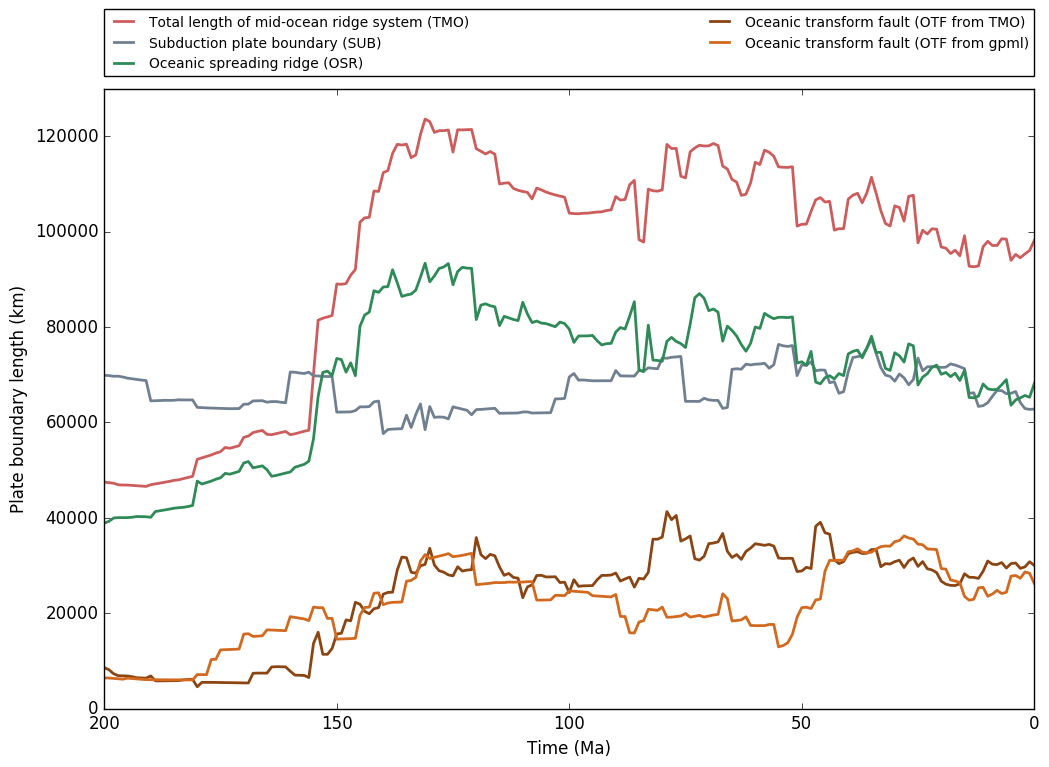

yes


In [24]:
# create empty arrays to write to
ridge_length=[]
transform_length=[]
subduction_length=[]
transformgpml_length = []

# set up times
min_time = 0
max_time = 200
time_step = 1

# Set up time array
times = np.arange(min_time,max_time + 1,time_step)

# deviation angle (in degrees) to split transforms vs. ridges from
deviation_angle= 70

# import previously made file
file = 'PlateBoundaryTypes_14March17.h5'
df = pd.read_hdf(file,'Statistics_table')
tags = df['FeatureType']

# print tags.unique()

for time in times:
    subset = df[(df['Time_Ma']>=time) 
                & (df['Time_Ma']<(time+time_step)) 
                & (df['FeatureType']=='gpml:MidOceanRidge')
                & (np.abs(df['Deviation_mod_deg'])<=deviation_angle)]
    ridge_length.append((np.sum(subset['Length_km']))/time_step)
    subset1 = df[(df['Time_Ma']>=time) 
                & (df['Time_Ma']<(time+time_step)) 
                & (df['FeatureType']=='gpml:MidOceanRidge')
                & (np.abs(df['Deviation_mod_deg'])>=deviation_angle)]
    transform_length.append((np.sum(subset1['Length_km']))/time_step)
    
    subset2 = df[(df['Time_Ma']>=time) 
                & (df['Time_Ma']<(time+time_step)) 
                & (df['FeatureType']=='gpml:Transform')]
    transformgpml_length.append((np.sum(subset2['Length_km']))/time_step)
        
    subset = df[(df['Time_Ma']>=time) 
                & (df['Time_Ma']<(time+time_step)) 
                & (df['FeatureType']=='gpml:SubductionZone')]
    subduction_length.append((np.sum(subset['Length_km']))/time_step)
 
   
# save file out just in case we need it later (or to plot in GMT)
dataout = np.vstack((times, ridge_length, transform_length, transformgpml_length, subduction_length)).T
np.savetxt('lengths_through_time.csv',dataout,delimiter=',',fmt='%0.1f',header='times, ridge,transform, transforms_gpml, subduction')

# colors
# ridge_color = 'firebrick'
# transform_color = 'orange'
# subduction_color = '#386cb0'
# transform_color2 = 'sage'
# fracturezone_color = 'darkorchid'
# continentalrift_color = 'burlywood'
# inferredpaleobound_color = '#ffff99'
# extendedcontinentalcrust_color = 'lightseagreen'
# other_color = 'black'
# backarc_transform_color = 'grey'
# backarc_ridge_color = 'blue'

from matplotlib import style

#style.use('ggplot')
alpha=1
fig = plt.figure(figsize=(12,8))
plt.plot(total_boundary, label = "Total length of mid-ocean ridge system (TMO)", color='#cd5c5c', linewidth=2)
plt.plot(subduction_length, label = "Subduction plate boundary (SUB)",color='#708090', linewidth=2)
plt.plot(ridge_length, label = "Oceanic spreading ridge (OSR)",color='#2e8b57', linewidth=2)
plt.plot(transform_length, label = "Oceanic transform fault (OTF from TMO)",color='#8b4513', linewidth=2)
plt.plot(transformgpml_length, label = "Oceanic transform fault (OTF from gpml)",color='#d2691e', linewidth=2)


plt.xlim(max_time,min_time)
plt.ylim(0,130000)
plt.xlabel('Time (Ma)', fontsize=12)
plt.ylabel('Plate boundary length (km)', fontsize=12)
plt.legend(loc='best',fontsize=11)
plt.legend(fontsize=10, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

plt.show()
print "yes"
#plt.savefig('Plate boundaries.svg',transparent=True)


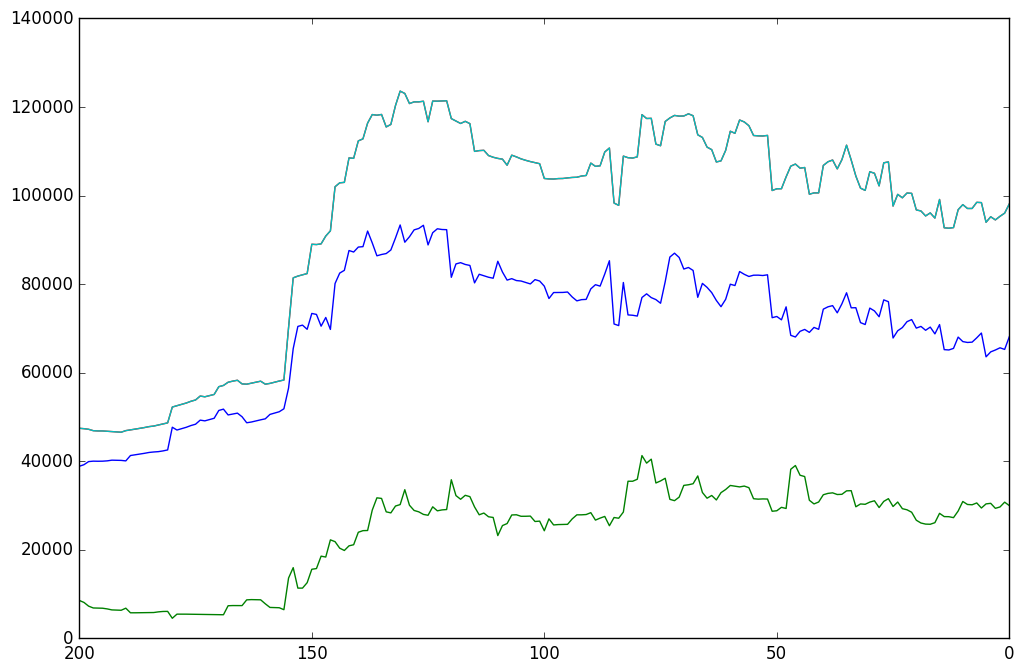

In [25]:
fig = plt.figure(figsize=(12,8))
plt.plot(ridge_length)
plt.hold (True)
plt.plot(transform_length)
plt.plot(total_boundary)
plt.hold(True)
plt.gca().invert_xaxis()
plt.plot(total_boundary)

In [22]:
print transform_length

[29993.20331305549, 30774.837620359445, 29691.097652001787, 29381.262828315164, 30509.510663261604, 30382.593062310403, 29452.79334633739, 30596.436677562597, 30183.544424746287, 30251.60187536308, 30925.874303095905, 28770.846840522652, 27277.70190943943, 27491.95129206168, 27515.14373223105, 28251.915440519286, 26145.17435438355, 25784.15123264784, 25818.304821191403, 26065.077786407357, 26693.613456574378, 28497.64698775625, 29051.949553585793, 29303.004240259565, 30803.144370045426, 29794.770719753793, 31563.28502257683, 30949.27643382831, 29556.732358952875, 31084.933311717494, 30789.0917769509, 30290.59635138904, 30369.169336619063, 29732.35818397377, 33367.5279835713, 33328.87335656865, 32545.380678801594, 32500.44158734306, 32878.08745043803, 32754.62778346908, 32446.207483526105, 30809.642026613757, 30374.199012552483, 31202.365534403754, 36556.6606031684, 36849.4311875196, 39045.654662868554, 38205.10878340331, 29346.081411794923, 29606.67404433305, 28834.85253675827, 28717.6

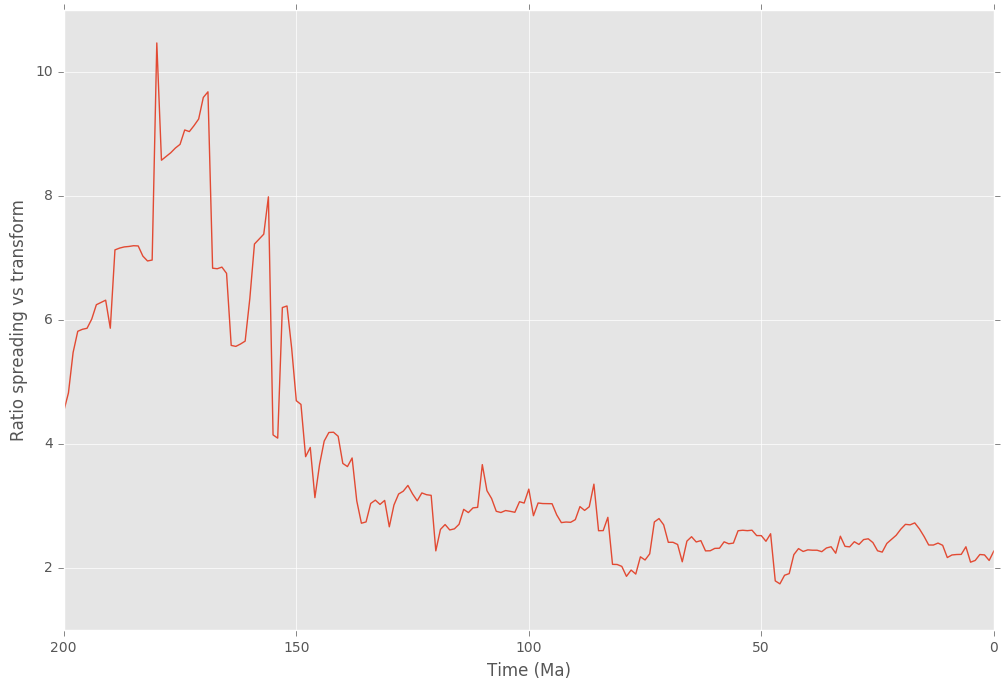

In [30]:
#Ratio of transform vs. spreading 

#Choose one or the other
#total_ratiotransform = [Transform / MOR for Transform,MOR in zip(transform_length,ridge_length)]
total_ratiotransform = [MOR / Transform for MOR,Transform in zip(ridge_length,transform_length,)]


fig = plt.figure(figsize=(12,8))
plt.plot(total_ratiotransform) 
plt.gca().invert_xaxis()
plt.xlim(max_time,min_time)
#plt.ylim(0,140000)
plt.xlabel('Time (Ma)', fontsize=12)
plt.ylabel('Ratio spreading vs transform', fontsize=12)
plt.legend(loc='best',fontsize=12)

plt.show()


In [31]:
print total_ratiotransform

[2.271335967704675, 2.1206992911100406, 2.210456004913099, 2.216715989701564, 2.120940679790818, 2.092978609171907, 2.3414868446664925, 2.2186475260420906, 2.2166243354216686, 2.2093294943727937, 2.167555582116724, 2.3650894666999207, 2.4011428493982003, 2.369400962763217, 2.3701781540957882, 2.5086333538825283, 2.63042879052544, 2.7265995153677594, 2.695193750460058, 2.7032165500425855, 2.625117536489225, 2.526639456890892, 2.462052483902794, 2.395544684431965, 2.2554458655668825, 2.2769647944248415, 2.4091889330296214, 2.4702392496910397, 2.457519131017237, 2.3791566528436965, 2.4227588047359463, 2.3401612044309976, 2.348270354091093, 2.5117418022397993, 2.237482872107845, 2.341930196318148, 2.3217665079388197, 2.262328601945286, 2.2858057140178785, 2.286132621501126, 2.2915988367042175, 2.2656558877243906, 2.312218974068593, 2.2148573153486035, 1.9087867152250741, 1.8819219291554214, 1.7433555149498332, 1.7914441800619907, 2.5514847940218974, 2.430077775525287, 2.521218954525473, 2.